## Electricity Usage Time Series Analysis

This dataset looks at measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years; the data is initially messy, and will take a lot of cleaning. You will find that there is some correlation between the data (i.e. what we know about the current state can tell us something about the future state), and you will then construct an Autoregressive Model to predict future values.

Source: https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption

Variable Descriptions:
1. date: Date in format dd/mm/yyyy <br> 
2. time: time in format hh:mm:ss <br>
3. global_active_power: household global minute-averaged active power (in kilowatt) <br>
4. global_reactive_power: household global minute-averaged reactive power (in kilowatt) <br>

In [38]:
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AR
from sklearn.model_selection import train_test_split
import numpy as np
import datetime

sns.set_style('darkgrid')
%matplotlib inline

In [19]:
#read in the data
pwr_consumption = pd.read_csv('household_power_consumption.txt', sep=';',parse_dates=['Date'],skip_blank_lines=True,infer_datetime_format=True,
                              usecols=['Date', 'Global_active_power', 'Global_reactive_power'])

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
pwr_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 3 columns):
Date                     datetime64[ns]
Global_active_power      object
Global_reactive_power    object
dtypes: datetime64[ns](1), object(2)
memory usage: 47.5+ MB


In [23]:
#remove strings and errors terms from the columns so they can be converted to numeric values

index_list = []

for ind, row in pwr_consumption.iterrows(): 
    try:
        np.float(row.Global_active_power)
    except:
        index_list.append(ind)
                
pwr_consumption.drop(pwr_consumption.index[index_list],inplace=True)
pwr_consumption['Global_active_power'] = pwr_consumption.Global_active_power.astype(float)

#remove strings and errors terms from the columns so they can be converted to numeric values
index_list2 = []

for ind, row in pwr_consumption.iterrows(): 
    try:
        np.float(row.Global_reactive_power)
    except:
        index_list2.append(ind)
                
pwr_consumption.drop(pwr_consumption.index[index_list2],inplace=True)
pwr_consumption['Global_reactive_power'] = pwr_consumption.Global_reactive_power.astype(float)

In [24]:
#aggregate data
pwr_consumption = pwr_consumption.groupby('Date').sum()
pwr_consumption.head()

,Global_active_power,Global_reactive_power
Date,,
2006-12-16,1209.176,34.922
2006-12-17,3390.460,226.006
2006-12-18,2203.826,161.792
2006-12-19,1666.194,150.942
2006-12-20,2225.748,160.998


In [51]:
'2010-12-02' in pwr_consumption.index

False

### Part 2: Visualizing Time-Series (10 points)
Plot data for 'global_active_pwr' and 'global_reactive_pwr' on a time-series. In addition to a standard line plot, also generate a plot using lag_plot() function to examine the correlation. So, your output should have 4 plots. Describe your findings.
<br><br>
Make a function that takes 2 arguments (you may use additional) - a plotting function & data containing the 2 required columns (global_active_pwr, global_reactive_pwr) and then generates the plot specified.
<br><br>
Make sure the plots have a title and the axes are labelled. (10 points)

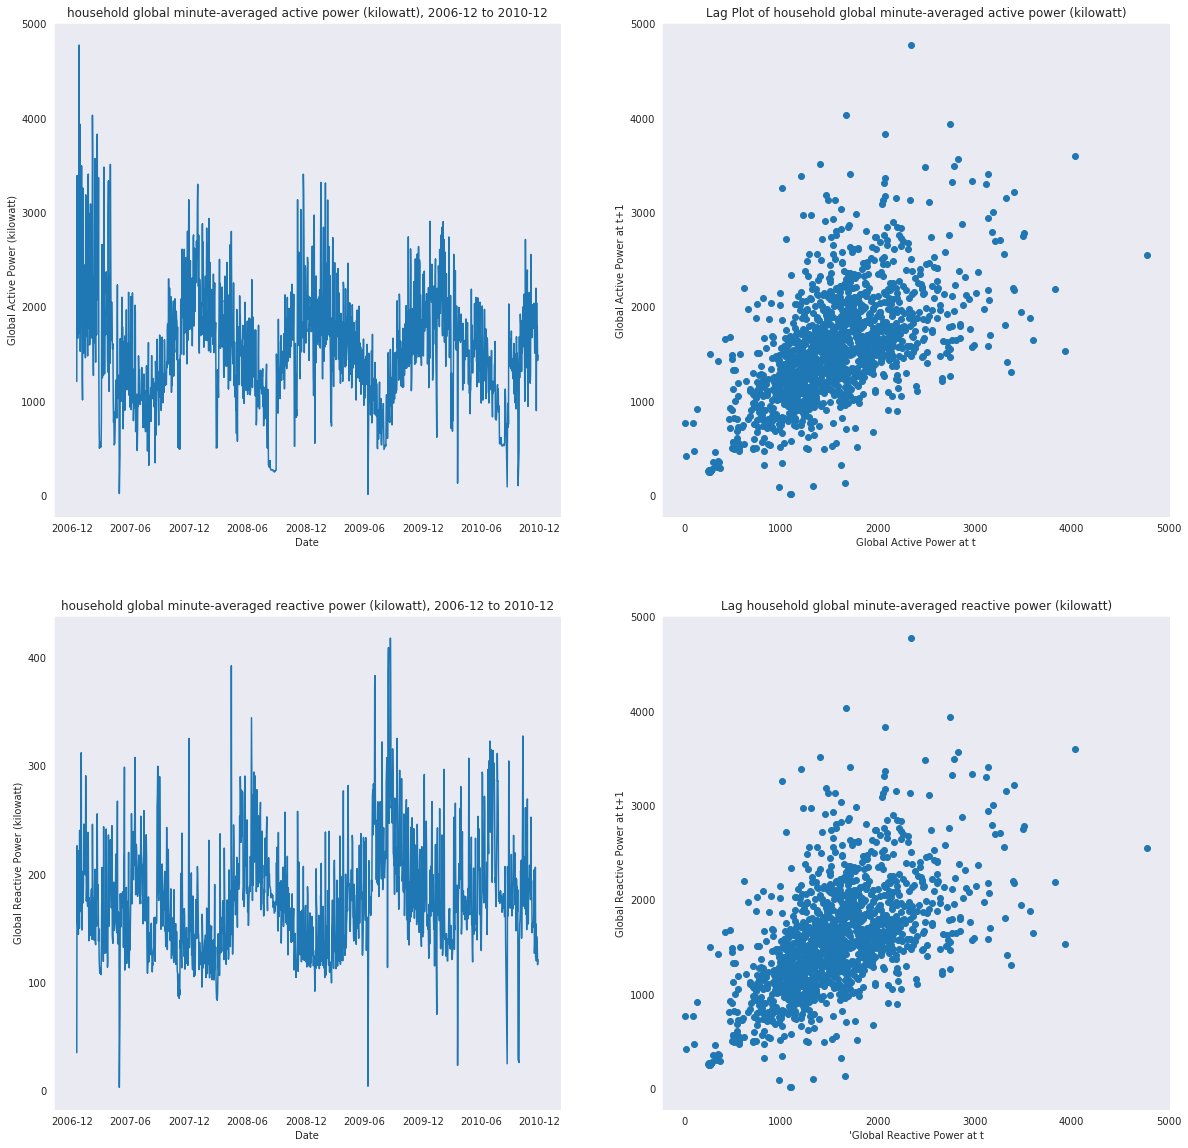

In [39]:
glb_active_pwr   = pwr_consumption['Global_active_power']
glb_reactive_pwr = pwr_consumption['Global_reactive_power'] 

def time_series_plotting(func, series1, series2):
    """
    takes plotting function, 2 time-series and additional arguments (if required)
    """
    fig = plt.figure(figsize=(20,20)) #initialize figure    
    
    ######PLOT 1################
    
    ax1 = fig.add_subplot(221) #initialize subplot for plot 1
    ax1.plot(series1) #format plot
    ax1.set_xlabel("Date") #x label added
    ax1.set_ylabel("Global Active Power (kilowatt)") #add Y label
    ax1.grid(False)
    ax1.set_title('household global minute-averaged active power (kilowatt), 2006-12 to 2010-12')
    
    ######PLOT 2################    
    
    ax2 = fig.add_subplot(222) 
    func(series1,ax=ax2)
    ax2.set_xlabel("Global Active Power at t") #x label added
    ax2.set_ylabel("Global Active Power at t+1") #add Y label
    ax2.grid(False)
    ax2.set_title('Lag Plot of household global minute-averaged active power (kilowatt)')   

    ######PLOT 3################
    
    ax3 = fig.add_subplot(223)
    ax3.plot(series2) #format plot
    ax3.set_xlabel("Date") #x label added
    ax3.set_ylabel("Global Reactive Power (kilowatt)") #add Y label
    ax3.grid(False)
    ax3.set_title('household global minute-averaged reactive power (kilowatt), 2006-12 to 2010-12')
    
    ####PLOT 4############
    
    ax4 = fig.add_subplot(224)
    func(series1,ax=ax4)
    ax4.set_xlabel("'Global Reactive Power at t") #x label added
    ax4.set_ylabel("Global Reactive Power at t+1") #add Y label
    ax4.grid(False)
    ax4.set_title('Lag household global minute-averaged reactive power (kilowatt)')  
    
    plt.show()

time_series_plotting(lag_plot, glb_active_pwr, glb_reactive_pwr)

#### The lag plot for both series suggest there is possible autocorrelation in the data, given that we are seeing positive serial dependence (based on the visual in the lag plot. 

### Fitting the data to a Autoregression model


In [114]:
def fit_AR1(series):
    """
    Takes in a Time-series, splits into train and test, fits AR(1) model, predicts on the test set, calculates error
    and return the predictions and the test set for visualization
    """
    # Perform a train-test split on the dataset keeping ~70% for the training set
    train, test = series[1:len(series)-30], series[len(series)-30:]
    
    # Fit AR(1) model
    model = AR(train)
    model_fit = model.fit(maxlag=1)
    
    # Get the predictions in an array
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    predict_series = pd.Series(data=predictions,index=test.index)
    
    error = np.sqrt(((np.array(predictions) - np.array(test)) ** 2)).mean()

    return test, predictions, error


t1, p1, e1 = fit_AR1(glb_active_pwr)
t2, p2, e2 = fit_AR1(glb_reactive_pwr)

print("the RMSE for the Global Active is:", e1)
print("the RMSE for the Global Reactive is:", e2)

the RMSE for the Global Active is: 284.766267799
the RMSE for the Global Reactive is: 31.0407044483


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No

In [103]:
predict = pd.Series(data=p1.values,index=t1.index)
predict2 = pd.Series(data=p2.values,index=t2.index)

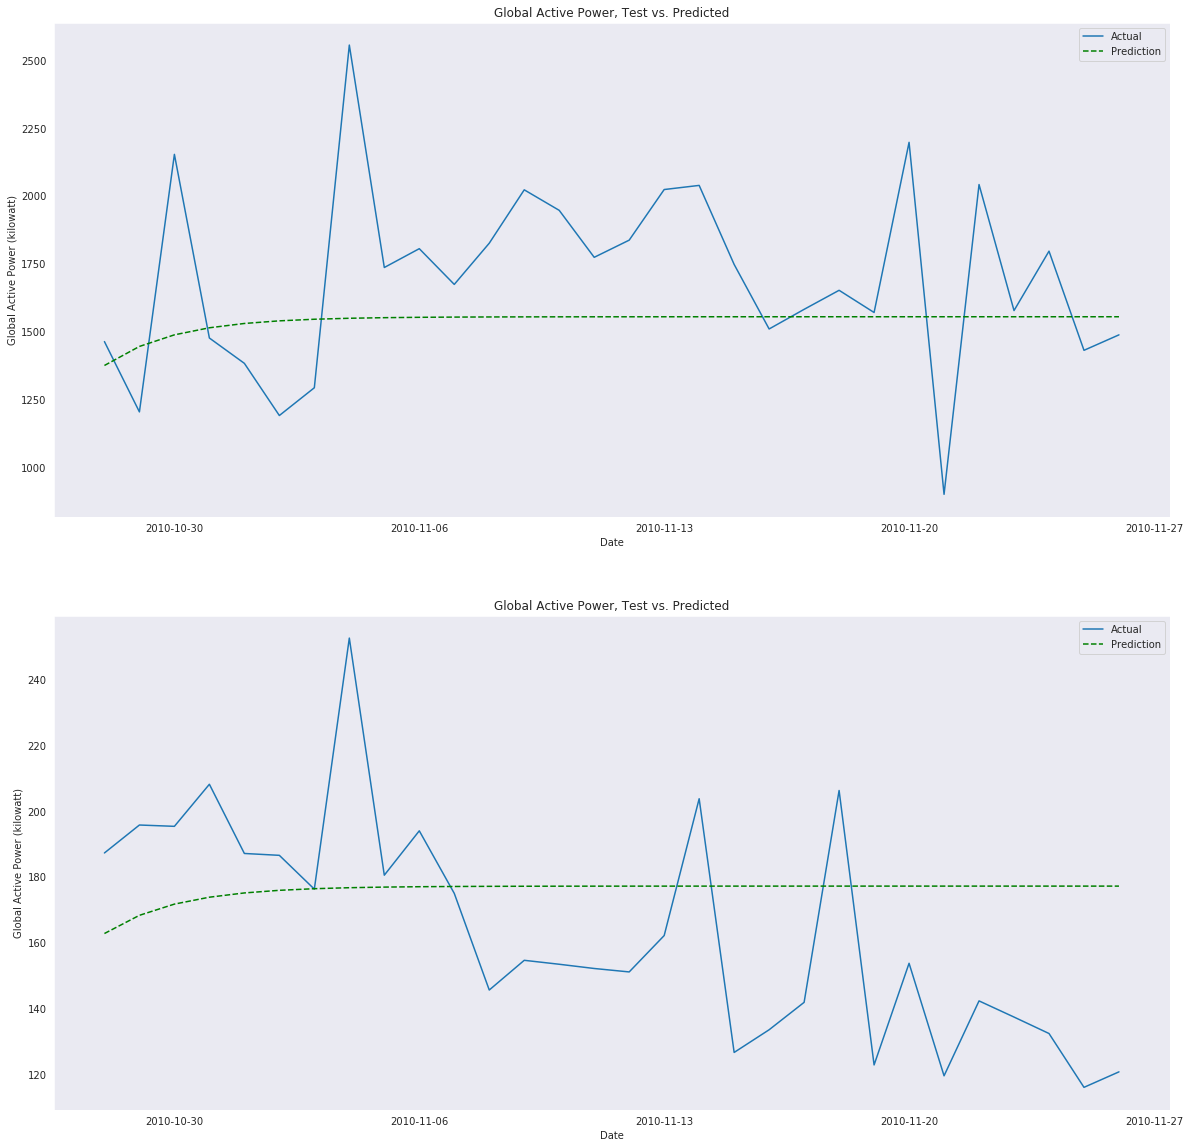

In [113]:
fig = plt.figure(figsize=(20,20)) #initialize figure    
    
ax1 = fig.add_subplot(211) #initialize subplot for plot 1
ax1.plot(t1,label='Actual')
ax1.plot(predict,color='green',linestyle='dashed',label='Prediction')
ax1.set_xlabel("Date") #x label added
ax1.set_ylabel("Global Active Power (kilowatt)") #add Y label
ax1.grid(False)
ax1.set_title('Global Active Power, Test vs. Predicted from AR(1) Model') 
ax1.legend()

ax2 = fig.add_subplot(212) #initialize subplot for plot 1
ax2.plot(t2,label='Actual')
ax2.plot(predict2,color='green',linestyle='dashed',label='Prediction')
ax2.set_xlabel("Date") #x label added
ax2.set_ylabel("Global Active Power (kilowatt)") #add Y label
ax2.grid(False)
ax2.set_title('Global Active Power, Test vs. Predicted from AR(1) Model') 
ax2.legend()


#### The results of the test make sense. You're training the model on a large data set that has a lot of noise but that has a fairly consistent mean, so our prediction result is relatively flat, around the same levels you see in the training data. However, once this is compared to the 30 day test data set, we get a large RMSE because there is significant noise in the 30 day test set that our model hasn't picked up from the long term training set (where short term fluctuations cancel each other out). Overall, it is probably a good approach if you want to understand the long term moving average, but it's not an effective model for predicting short term fluctuations or momentum.